Previous notebook is `/pscratch/sd/y/yaswante/MyQuota/roman_lsst/LSST_Roman_Cutouts_Catalogs.ipynb`.

# Verify Cutouts, Catalogs, WCS

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb, AsinhStretch, ImageNormalize
import multiprocessing as mp
from tqdm import tqdm
from functools import partial

In [ ]:
def verify_worker(cutout_id: int, tile: str, lsst_dir: str, wcs_data: dict):
    """
    Checks a single cutout for file existence and content validity.
    This function is designed to be called by a multiprocessing Pool.
    """
    base_filename = f"c{cutout_id}_{tile}"
    lsst_tile_dir = os.path.join(lsst_dir, tile)

    img_path = os.path.join(lsst_tile_dir, f"{base_filename}.npy")
    truth_path = os.path.join(lsst_tile_dir, f"truth_{base_filename}.json")
    det_path = os.path.join(lsst_tile_dir, f"det_{base_filename}.json")

    errors = []

    if not os.path.exists(img_path):
        errors.append("Image file (.npy) is missing.")
    else:
        try:
            img_data = np.load(img_path, mmap_mode='r')
            if img_data.shape[1] == 0 or img_data.shape[2] == 0:
                errors.append("Image file (.npy) contains an empty array.")
        except Exception as e:
            errors.append(f"Could not read or validate image file: {e}")

    if not os.path.exists(truth_path):
        errors.append("Truth catalog (.json) is missing.")
    else:
        if os.path.getsize(truth_path) < 5:
             errors.append("Truth catalog (.json) is an empty file.")

    if not os.path.exists(det_path):
        errors.append("Detection catalog (.json) is missing.")
        
    wcs_key = f"c{cutout_id}"
    wcs_header = wcs_data.get(wcs_key)
    if wcs_header is None:
        errors.append("WCS header is missing from the tile's JSON file.")
    elif isinstance(wcs_header, str) and not wcs_header.strip():
        errors.append("WCS header is an empty string.")

    if errors:
        return {'tile': tile, 'cutout_id': cutout_id, 'errors': errors}
    
    return None

In [ ]:
def stretch_color(data, clipPercent):
    return np.percentile(data, (0 + clipPercent, 100 - clipPercent))

def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))

class CutoutVerifier:
    """
    A tool to verify and visualize LSST and Roman cutouts, catalogs, and WCS files.
    """
    def __init__(self, lsst_dir: str, roman_dir: str, tile_list_file: str):
        """
        Initializes the verifier with necessary directory paths.

        Args:
            lsst_dir (str): Root directory for the processed LSST data.
            roman_dir (str): Root directory for the Roman truth data.
            tile_list_file (str): Path to the text file containing the list of tiles.
        """
        self.lsst_dir = lsst_dir
        self.roman_dir = roman_dir
        self.cutouts_per_tile = 225
        
        print("Loading tile list...")
        with open(tile_list_file, 'r') as f:
            self.all_tiles = [line.strip() for line in f if line.strip()]
        print(f"Found {len(self.all_tiles)} tiles.")

    def load_cutout(self, tile: str, cutout_id: int) -> dict:
        """Loads all data for a specific cutout, including images and catalogs."""
        base_filename = f"c{cutout_id}_{tile}"
        lsst_tile_dir = os.path.join(self.lsst_dir, tile)
        roman_tile_dir = os.path.join(self.roman_dir, tile)

        paths = {
            'lsst_img': os.path.join(lsst_tile_dir, f"{base_filename}.npy"),
            'truth_cat': os.path.join(lsst_tile_dir, f"truth_{base_filename}.json"),
            'det_cat': os.path.join(lsst_tile_dir, f"det_{base_filename}.json"),
            'roman_img': os.path.join(roman_tile_dir, f"{base_filename}.npy"),
            'roman_truth': os.path.join(roman_tile_dir, f"truth_{base_filename}.json"),
            'roman_det': os.path.join(roman_tile_dir, f"det_{base_filename}.json"),
        }
        
        data = {'tile': tile, 'cutout_id': cutout_id, 'is_empty': True}

        if not os.path.exists(paths['lsst_img']):
            print(f"Warning: LSST image not found for cutout {cutout_id} in tile {tile}.")
            return data

        try:
            lsst_img = np.load(paths['lsst_img'])
            data['lsst_img'] = lsst_img
            data['is_empty'] = lsst_img.shape[1] == 0 or lsst_img.shape[2] == 0
            
            # Load catalogs, returning empty DataFrames if they don't exist
            data['truth_cat'] = pd.read_json(paths['truth_cat']) if os.path.exists(paths['truth_cat']) else pd.DataFrame()
            data['det_cat'] = pd.read_json(paths['det_cat']) if os.path.exists(paths['det_cat']) else pd.DataFrame()
            
            # Load Roman data if available
            if os.path.exists(paths['roman_img']):
                data['roman_img'] = np.load(paths['roman_img'])
                data['roman_truth'] = pd.read_json(paths['roman_truth']) if os.path.exists(paths['roman_truth']) else pd.DataFrame()
                data['roman_det'] = pd.read_json(paths['roman_det']) if os.path.exists(paths['roman_det']) else pd.DataFrame()
            else:
                data['roman_img'], data['roman_truth'], data['roman_det'] = None, None, None
                
            return data
        except Exception as e:
            print(f"Error loading data for cutout {cutout_id} in tile {tile}: {e}")
            return {'tile': tile, 'cutout_id': cutout_id, 'is_empty': True}

    def get_random_cutout(self, tile: str = None, cutout_id: int = None, exclude_empty: bool = True) -> dict:
        """Gets a random cutout. Can specify tile and/or cutout_id."""
        max_attempts = 10 if exclude_empty else 1
        for _ in range(max_attempts):
            selected_tile = tile or random.choice(self.all_tiles)
            selected_cutout_id = cutout_id if cutout_id is not None else random.randint(0, self.cutouts_per_tile - 1)
            
            data = self.load_cutout(selected_tile, selected_cutout_id)
            
            if not exclude_empty or not data['is_empty']:
                return data
        
        print(f"Could not find a valid non-empty cutout after {max_attempts} attempts.")
        return None

    def print_summary(self, data: dict):
        """Prints a summary of statistics for a given cutout's data."""
        if not data:
            print("Invalid data dictionary provided.")
            return
            
        print(f"\n{'='*20} Cutout Summary {'='*20}")
        print(f"Tile: {data['tile']}")
        print(f"Cutout ID: {data['cutout_id']}")
        print(f"Is Empty: {data['is_empty']}")
        
        if not data.get('is_empty', True):
            print(f"\nImage shapes:")
            print(f"  LSST: {data['lsst_img'].shape}")
            if data.get('roman_img') is not None:
                print(f"  Roman: {data['roman_img'].shape}")

            print(f"\nObject counts:")
            print(f"  LSST Truth: {len(data.get('truth_cat', []))}")
            print(f"  LSST Detections: {len(data.get('det_cat', []))}")
            if data.get('roman_truth') is not None:
                 print(f"  Roman Truth: {len(data.get('roman_truth', []))}")
                 print(f"  Roman Detections: {len(data.get('roman_det', []))}")

            truth_cat = data.get('truth_cat')
            if truth_cat is not None and not truth_cat.empty and 'truth_type' in truth_cat.columns:
                 print(f"\nLSST Truth Catalog Breakdown:")
                 print(f"  Galaxies (type 1): {len(truth_cat[truth_cat['truth_type'] == 1])}")
                 print(f"  Stars (type 2): {len(truth_cat[truth_cat['truth_type'] == 2])}")
        print(f"{'='*58}\n")

    def plot_cutout_lsst(self, data: dict, band: str = 'i', wcs_verify_coords: dict = None):
        """Plots the LSST Cutout with optional catalog overlays."""
        if data['is_empty']:
            print("Cannot plot an empty cutout.")
            return

        band_indices = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
        lsst_img = data['lsst_img'][band_indices.get(band, 3)]

        plt.figure(figsize=(8, 8))
        plt.imshow(lsst_img, origin='lower', cmap='viridis', norm=asinh_norm(lsst_img))
        
        title = f"LSST - ${band}$-band | Tile: {data['tile']}, Cutout: {data['cutout_id']}"
        if wcs_verify_coords:
            title += " (WCS Verified)"
            truth_coords = wcs_verify_coords.get('truth')
            det_coords = wcs_verify_coords.get('det')
            if truth_coords:
                plt.scatter(truth_coords[0], truth_coords[1], s=40, facecolors='none', edgecolors='r', marker='o', label='Truth (WCS)')
            if det_coords:
                plt.scatter(det_coords[0], det_coords[1], s=40, color='k', marker='x', label='Detections (WCS)')
        else:
            if not data['truth_cat'].empty:
                plt.scatter(data['truth_cat']['cutout_x'], data['truth_cat']['cutout_y'], s=40, facecolors='none', edgecolors='r', marker='o', label='Truth')
            if not data['det_cat'].empty:
                plt.scatter(data['det_cat']['cutout_x'], data['det_cat']['cutout_y'], s=40, color='k', marker='x', label='Detections')

        plt.title(title)
        plt.xlabel("X pixel")
        plt.ylabel("Y pixel")
        if wcs_verify_coords or not data['truth_cat'].empty or not data['det_cat'].empty:
            plt.legend()
        plt.show()

    def plot_cutout_both(self, data: dict, lsst_band: str = 'i', plot_catalogs: bool = True):
        """Plots both LSST and Roman cutouts side-by-side."""
        if data['is_empty']:
            print("Cannot plot an empty cutout.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f"Tile: {data['tile']}, Cutout: {data['cutout_id']}", fontsize=16)

        # LSST Plot
        band_indices = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
        lsst_img = data['lsst_img'][band_indices.get(lsst_band, 3)]
        axes[0].imshow(lsst_img, origin='lower', cmap='viridis', norm=asinh_norm(lsst_img))
        axes[0].set_title(f"LSST - ${lsst_band}$-band")
        if plot_catalogs:
            if not data['truth_cat'].empty:
                axes[0].scatter(data['truth_cat']['cutout_x'], data['truth_cat']['cutout_y'], s=40, facecolors='none', edgecolors='r', marker='o', label='Truth')
            if not data['det_cat'].empty:
                axes[0].scatter(data['det_cat']['cutout_x'], data['det_cat']['cutout_y'], s=40, c='k', marker='x', label='Detections')
        
        # Roman Plot
        if data['roman_img'] is not None:
            r, g, b = data['roman_img'][2], data['roman_img'][1], data['roman_img'][0]
            pmin = np.percentile([r, g, b], 1)
            pmax = np.percentile([r, g, b], 99.5)
            stretch = pmax - pmin # ~27.160368
            roman_img = make_lupton_rgb(r, g, b, minimum=pmin, stretch=stretch, Q=8)
            axes[1].imshow(roman_img, origin='lower')
            axes[1].set_title("Roman - Y106, J129, H158")
            if plot_catalogs:
                if data['roman_truth'] is not None and not data['roman_truth'].empty:
                    axes[1].scatter(data['roman_truth']['cutout_x'], data['roman_truth']['cutout_y'], s=40, c='r', facecolors='none', edgecolors='r', marker='o')
                if data['roman_det'] is not None and not data['roman_det'].empty:
                    axes[1].scatter(data['roman_det']['cutout_x'], data['roman_det']['cutout_y'], s=40, c='k', facecolors='none', edgecolors='r', marker='x')
        else:
            axes[1].text(0.5, 0.5, "No Roman Data", ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title("Roman")
            
        if plot_catalogs:
            fig.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    def verify_wcs(self, tile: str, cutout_id: int):
        """Verifies the WCS by re-projecting catalog coordinates onto the image."""
        print(f"Verifying WCS for Tile {tile}, Cutout {cutout_id}...")
        wcs_path = os.path.join(self.lsst_dir, tile, f"wcs_{tile}.json")
        if not os.path.exists(wcs_path):
            print(f"WCS file not found at {wcs_path}")
            return
            
        with open(wcs_path, 'r') as f:
            wcs_data = json.load(f)
        
        wcs_header_str = wcs_data.get(f"c{cutout_id}")
        if not wcs_header_str:
            print(f"WCS header for cutout c{cutout_id} not found in file.")
            return
        
        wcs = WCS(wcs_header_str)
        data = self.load_cutout(tile, cutout_id)
        
        wcs_coords = {}
        # Verify Truth Catalog
        if not data['truth_cat'].empty:
            truth_skycoords = SkyCoord(ra=data['truth_cat']['ra'].values*u.deg, dec=data['truth_cat']['dec'].values*u.deg)
            pix_coords = wcs.world_to_pixel(truth_skycoords)
            wcs_coords['truth'] = pix_coords
            print("\nComparing Truth Catalog Coords (first 5):")
            print("  Catalog XY  |  WCS-derived XY")
            for i in range(min(5, len(data['truth_cat']))):
                print(f"  ({data['truth_cat']['cutout_x'].iloc[i]:.2f}, {data['truth_cat']['cutout_y'].iloc[i]:.2f}) |  ({pix_coords[0][i]:.2f}, {pix_coords[1][i]:.2f})")
        
        # Verify Detection Catalog
        if not data['det_cat'].empty:
            det_skycoords = SkyCoord(ra=data['det_cat']['ra'].values*u.deg, dec=data['det_cat']['dec'].values*u.deg)
            pix_coords = wcs.world_to_pixel(det_skycoords)
            wcs_coords['det'] = pix_coords

        self.plot_cutout_lsst(data, wcs_verify_coords=wcs_coords)

    def verify_all_cutouts(self, num_workers: int = 32):
        """
        Verifies all cutouts across all tiles for data file and WCS header integrity.
        Uses multiprocessing for efficiency.

        Args:
            num_workers (int): The number of parallel processes to use for verification.
        """
        print(f" Starting verification of all cutouts across {len(self.all_tiles)} tiles...")
        
        all_failures = []
        total_cutouts_checked = 0

        for tile in self.all_tiles:
            print(f"\n--- Verifying Tile: {tile} ---")
            wcs_path = os.path.join(self.lsst_dir, tile, f"wcs_{tile}.json")
            
            if not os.path.exists(wcs_path):
                print(f"  FATAL ERROR: WCS file missing for the entire tile at {wcs_path}")
                print(f"  Skipping all 225 cutouts for this tile.")
                for cid in range(self.cutouts_per_tile):
                    all_failures.append({
                        'tile': tile, 
                        'cutout_id': cid, 
                        'errors': ['Parent WCS JSON file is missing.']
                    })
                total_cutouts_checked += self.cutouts_per_tile
                continue

            with open(wcs_path, 'r') as f:
                wcs_data = json.load(f)

            tasks = range(self.cutouts_per_tile)
            
            worker_func = partial(verify_worker, tile=tile, lsst_dir=self.lsst_dir, wcs_data=wcs_data)

            with mp.Pool(processes=num_workers) as pool:
                results = list(tqdm(pool.imap_unordered(worker_func, tasks), total=len(tasks), desc=f"Checking {tile}"))
            
            tile_failures = [res for res in results if res is not None]
            if tile_failures:
                all_failures.extend(tile_failures)
            
            total_cutouts_checked += len(tasks)

        print("\n" + "="*20 + " Verification Complete " + "="*20)
        if not all_failures:
            print(f"Success! All {total_cutouts_checked} cutouts passed verification.")
        else:
            print(f" Found {len(all_failures)} cutouts with issues.")
            for i, failure in enumerate(all_failures[:10]):
                print(f"  - Tile: {failure['tile']}, Cutout: {failure['cutout_id']}")
                for error in failure['errors']:
                    print(f"    - {error}")
            if len(all_failures) > 10:
                print(f"  ... and {len(all_failures) - 10} more issues.")
        print("="*61 + "\n")
        
        return all_failures

In [ ]:
ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
LSST_DIR = f'{ROOT_DIR}truth-lsst/'
ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
COADD_DIR = f'{ROOT_DIR}full_coadd_butler_striped/' # striped folder containing our exposures
TILE_LIST_FILE = f'{ROOT_DIR}700_tiles.txt'

# Create an instance of the verifier
verifier = CutoutVerifier(
    lsst_dir=LSST_DIR,
    roman_dir=ROMAN_DIR,
    tile_list_file=TILE_LIST_FILE
)

In [ ]:
# just check if any of the cutouts, catalogs or WCS are empty
failed_cutouts = verifier.verify_all_cutouts(num_workers=256)
if failed_cutouts:
    print(f"\nThere were a total of {len(failed_cutouts)} failed cutouts.")
    failures_df = pd.DataFrame(failed_cutouts)
    print(failures_df.head())

```
Starting verification of all cutouts across 700 tiles...

--- Verifying Tile: 50.94_-39.9 ---
Checking 50.94_-39.9: 100%|██████████| 225/225 [00:00<00:00, 1897.10it/s]

--- Verifying Tile: 50.94_-41.4 ---
Checking 50.94_-41.4: 100%|██████████| 225/225 [00:00<00:00, 1853.37it/s]

--- Verifying Tile: 50.95_-39.0 ---
Checking 50.95_-39.0: 100%|██████████| 225/225 [00:00<00:00, 2121.44it/s]
```


In [ ]:
print("Fetching a random cutout...")
random_data = verifier.get_random_cutout()
if random_data:
    verifier.print_summary(random_data)
    
if random_data:
    print("\nPlotting the LSST cutout...")
    verifier.plot_cutout_lsst(random_data, band='i')

if random_data:
    print("\nPlotting both LSST and Roman cutouts...")
    verifier.plot_cutout_both(random_data, plot_catalogs=True)

# Verify the WCS for a specific cutout ---
# We use the tile and cutout ID from the random data we fetched
if random_data:
    tile_to_verify = random_data['tile']
    cutout_to_verify = random_data['cutout_id']
    print(f"\nVerifying WCS for a specific cutout: Tile {tile_to_verify}, ID {cutout_to_verify}")
    verifier.verify_wcs(tile=tile_to_verify, cutout_id=cutout_to_verify)

```
Fetching a random cutout...

==================== Cutout Summary ====================
Tile: 51.22_-39.4
Cutout ID: 44
Is Empty: False

Image shapes:
  LSST: (6, 148, 146)
  Roman: (3, 512, 512)

Object counts:
  LSST Truth: 135
  LSST Detections: 37
  Roman Truth: 142
  Roman Detections: 50

LSST Truth Catalog Breakdown:
  Galaxies (type 1): 135
  Stars (type 2): 0
==========================================================

Plotting the LSST cutout...
```

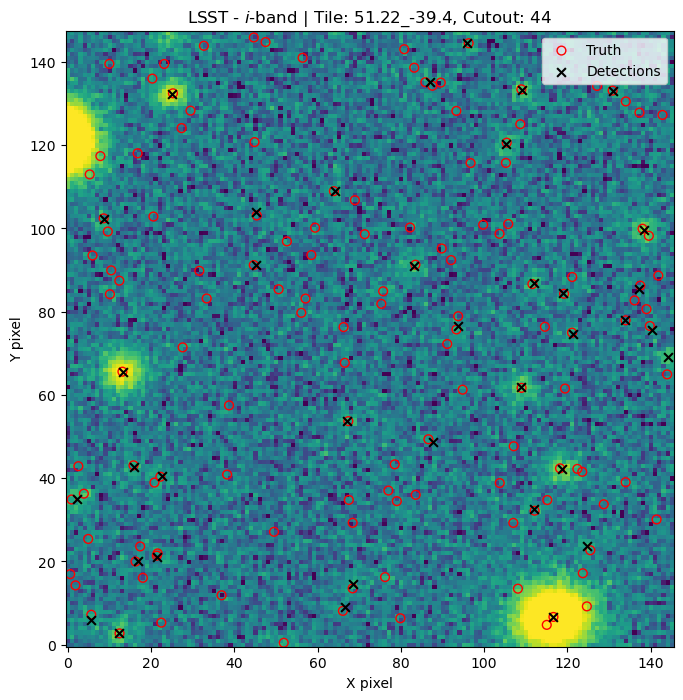

Plotting both LSST and Roman cutouts...
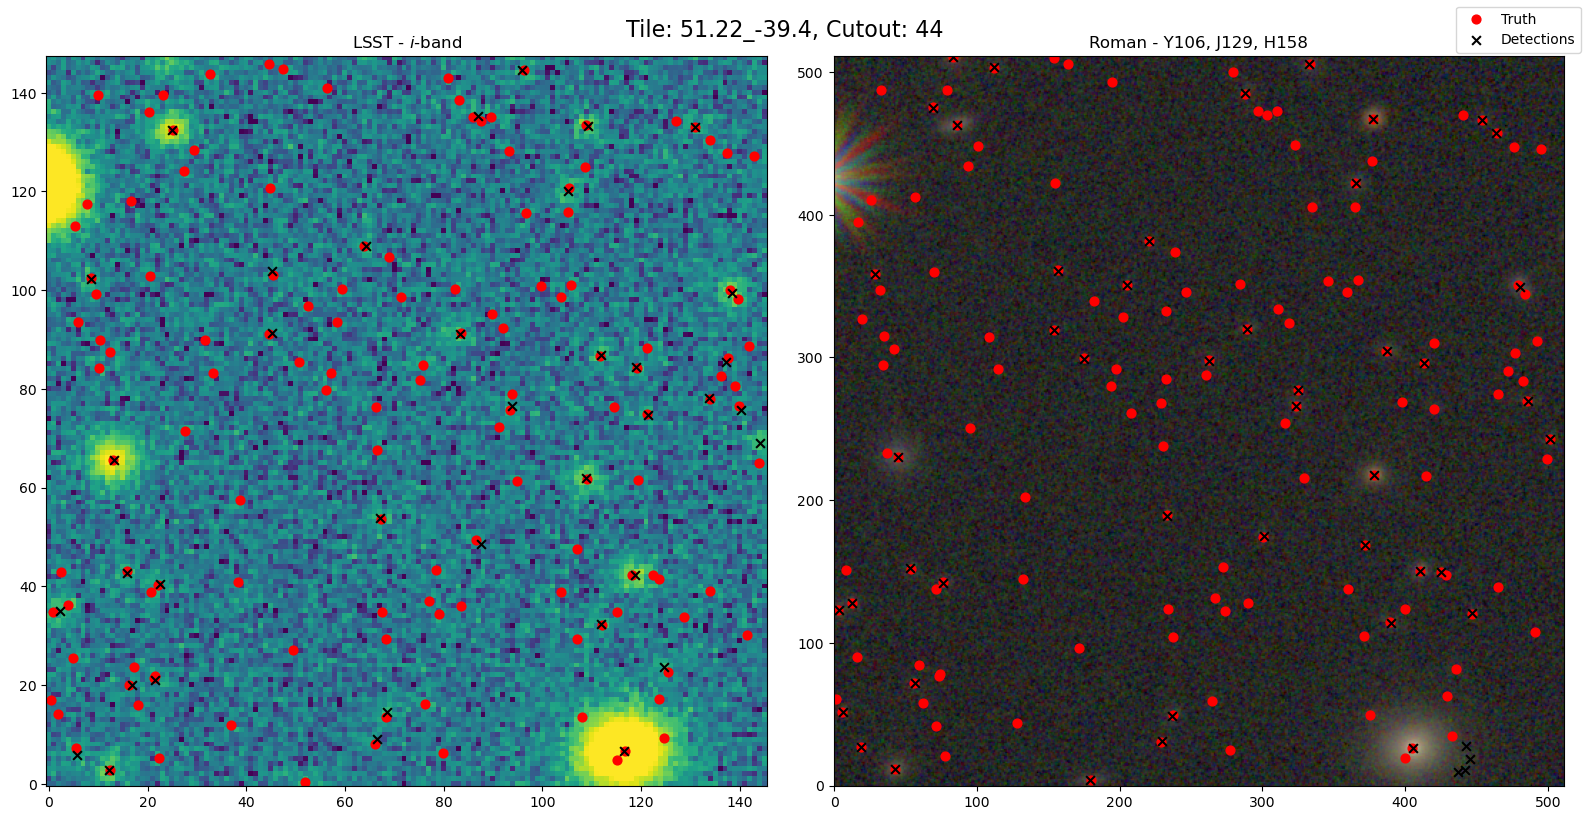
```
Verifying WCS for a specific cutout: Tile 51.22_-39.4, ID 44
Verifying WCS for Tile 51.22_-39.4, Cutout 44...

Comparing Truth Catalog Coords (first 5):
  Catalog XY  |  WCS-derived XY
  (56.05, 79.72) |  (56.05, 79.72)
  (105.41, 120.61) |  (105.41, 120.61)
  (106.99, 29.26) |  (106.99, 29.26)
  (105.78, 101.06) |  (105.78, 101.06)
  (141.42, 30.07) |  (141.42, 30.07)
```
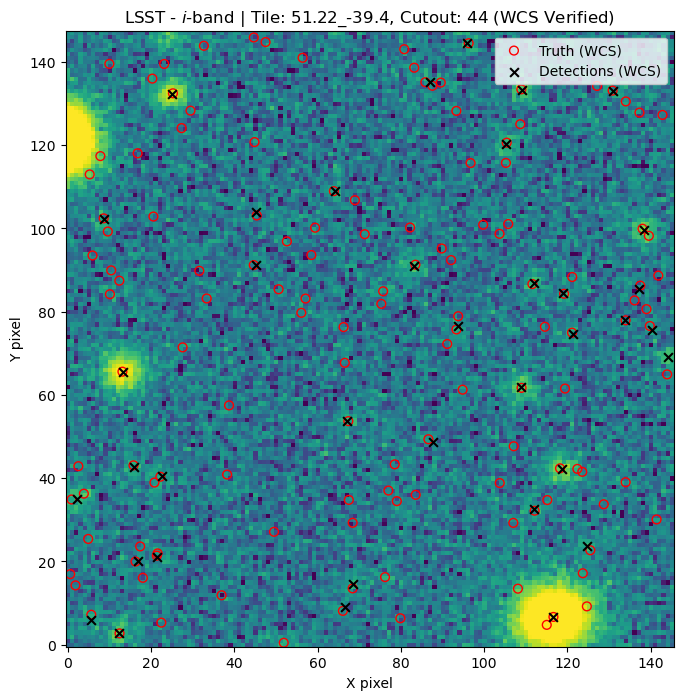